In [2]:
# import the dataset
import pandas as pd
master = pd.read_csv('cars.csv')

# Discard any categorical columns (can't easily be quantified)
master.drop(columns=['Engine Information.Engine Type', 'Identification.ID', 'Identification.Model Year'], axis=1, inplace=True)

master.head()

,Dimensions.Height,Dimensions.Length,Dimensions.Width,Engine Information.Driveline,Engine Information.Hybrid,Engine Information.Number of Forward Gears,Engine Information.Transmission,Fuel Information.City mpg,Fuel Information.Fuel Type,Fuel Information.Highway mpg,Identification.Classification,Identification.Make,Identification.Year,Engine Information.Engine Statistics.Horsepower,Engine Information.Engine Statistics.Torque
0,140,143,202,All-wheel drive,True,6,6 Speed Automatic Select Shift,18,Gasoline,25,Automatic transmission,Audi,2009,250,236
1,140,143,202,Front-wheel drive,True,6,6 Speed Automatic Select Shift,22,Gasoline,28,Automatic transmission,Audi,2009,200,207
2,140,143,202,Front-wheel drive,True,6,6 Speed Manual,21,Gasoline,30,Manual transmission,Audi,2009,200,207
3,140,143,202,All-wheel drive,True,6,6 Speed Automatic Select Shift,21,Gasoline,28,Automatic transmission,Audi,2009,200,207
4,140,143,202,All-wheel drive,True,6,6 Speed Automatic Select Shift,21,Gasoline,28,Automatic transmission,Audi,2009,200,207


In [3]:
# Develop standards for determining efficiency
#  Efficiency will be measured by taking the fuel efficiency (City and Highway), adding both, and dividing by 2

In [8]:
# Determine features to include in my analysis
# We want to operate on driveline, num gears, fuel type, classification, horsepower
mpg_df = master[
    [
         'Dimensions.Height',
         'Dimensions.Length',
         'Dimensions.Width',
         'Engine Information.Engine Statistics.Torque',
         'Engine Information.Driveline', 
         'Engine Information.Number of Forward Gears', 
         'Fuel Information.Fuel Type',
         'Identification.Classification',
         'Engine Information.Engine Statistics.Horsepower',
         'Fuel Information.City mpg',
         'Fuel Information.Highway mpg'
    ]
    ].copy()

# Drop any unneeded columns
mpg_df = mpg_df.drop(
    [
        'Engine Information.Driveline', 
        'Identification.Classification',
        'Fuel Information.Fuel Type'
    ]
    , axis=1)

# Rename to be more human-readable
mpg_df = mpg_df.rename(columns=
                       {
                            "Fuel Information.City mpg": "cityMpg",
                            "Fuel Information.Highway mpg": "highwayMpg",
                            "Dimensions.Height": "height",
                            "Dimensions.Length": "length",
                            "Dimensions.Width": "width",
                            "Engine Information.Engine Statistics.Torque": "torque",
                            "Engine Information.Number of Forward Gears": "numGears",
                            "Engine Information.Engine Statistics.Horsepower": "horsepower"
                       }
                      )

# Append whether each car is efficient or not (>= 22)
mpg_df['isCityEfficient'] = mpg_df.apply(lambda row: (row['cityMpg'] >= 22), axis=1)
mpg_df['isHighwayEfficient'] = mpg_df.apply(lambda row: (row['highwayMpg'] >= 22), axis=1)

mpg_df['isCombinedEfficient'] = mpg_df.apply(lambda row: (row['isCityEfficient'] & row['isHighwayEfficient']) , axis=1)


mpg_df.head()

,height,length,width,torque,numGears,horsepower,cityMpg,highwayMpg,isCityEfficient,isHighwayEfficient,isCombinedEfficient
0,140,143,202,236,6,250,18,25,False,True,False
1,140,143,202,207,6,200,22,28,True,True,True
2,140,143,202,207,6,200,21,30,False,True,False
3,140,143,202,207,6,200,21,28,False,True,False
4,140,143,202,207,6,200,21,28,False,True,False


In [9]:
# Split into training set and test set
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(mpg_df, test_size=0.2, random_state=42) # split 80/20, random seed
df_train[:10]

,height,length,width,torque,numGears,horsepower,cityMpg,highwayMpg,isCityEfficient,isHighwayEfficient,isCombinedEfficient
4651,180,176,239,144,6,156,25,34,True,True,True
2191,112,22,206,190,4,185,17,23,False,True,False
3456,77,185,240,335,6,315,11,16,False,False,False
4155,130,184,224,407,5,390,13,19,False,False,False
3858,203,223,64,258,6,220,18,29,False,True,False
759,132,169,85,240,5,210,16,24,False,True,False
2478,66,123,219,150,5,155,22,32,True,True,True
2525,231,5,214,270,6,288,16,22,False,True,False
4051,85,215,237,305,4,302,14,19,False,False,False
1437,183,153,107,288,4,292,15,23,False,True,False


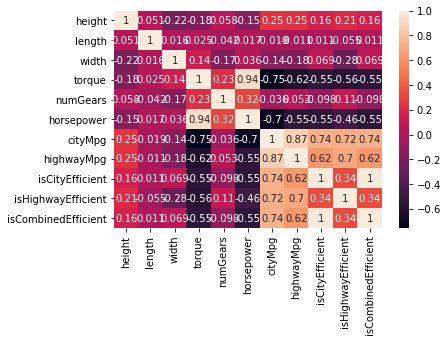

In [10]:
# Check for any correlations
corr_matrix = mpg_df.corr()
corr_matrix

import seaborn as sns

import matplotlib.pyplot as plt

# taking all rows but only 6 columns
df_small = mpg_df.iloc[:,:11]

correlation_mat = df_small.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [125]:
# Remove all MPG columns, because we want to predict those
df_train_labels = df_train.drop(['avgMPG', 'isEfficient'], axis=1)
df_test_labels = df_test.drop(['avgMPG', 'isEfficient'], axis=1)

In [126]:
# Train classifier on what is efficient
# df_train_efficient = (df_train.avg_mpg >= 22)
# df_test_efficient = (df_test.avg_mpg >= 22)

In [127]:
# Evaluate model and and make appropriate changes

In [128]:
# Run model on the test data

In [129]:
# How did it perform? What was precision and recall?